## SPH-6004 (2005) WORKING WITH MIMIC-CXR-EMBED DATA  

This script explains how to:  

- Mount the **mimic-cxr-embed** dataset and its labels from Google Drive.  
- Build a simple PyTorch **DataLoader** to load the data.  

### Why You Should Not Just Drag-and-Drop Files to Colab’s `Files` Tab  

You might wonder why we don’t simply drag and drop the data into the `Files` tab in Colab. The issue is that Colab's storage is **temporary**—if there's no activity for about an hour, the stored data resets. To avoid this, we need to keep our data **permanently in Google Drive**, allowing us to remount it whenever needed.  

### Other Colab’s Limitations  

Beyond the storage reset issue, Colab has other limitations that make it less ideal for model training:  

- **Limited RAM size**  
- **Free GPU availability is not always guaranteed**  

If you have access to a **personal server** or **desktop with a dedicated GPU**, I highly recommend using that instead.  


### Prerequisites

You have to have the following files/folders downloaded in your local working space.
* `files` : mimic-cxr-embed dataset from https://physionet.org/content/image-embeddings-mimic-cxr/
* `mimic-cxr-2.0.0-chexpert.csv` : train/valid label from https://physionet.org/content/mimic-cxr-jpg/2.1.0/
* `mimic-cxr-2.0.0-metadata.csv.gz` : meta data from https://physionet.org/content/mimic-cxr-jpg/2.1.0/


**Also nevigate to Edit->Notebook settings and turn on the GPU accelerator.**

### Mounting data to the working directory
Upload your data folder into google drive. Once done run the cell below. Now if you open the `files` tab on the left, you will see that a new folder `drive` is mounted. You will be able find your data in the folder.

### Loading packages

In [ ]:
import os
import os.path
import random

import numpy as np
import pandas as pd
from typing import Dict, List
import torch
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf

import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score


## Define helper functions for dataset class

In [ ]:
def load_embedding(embedding_path):
    raw_dataset = tf.data.TFRecordDataset([embedding_path])
    for raw_record in raw_dataset.take(1):
      example = tf.train.Example()
      example.ParseFromString(raw_record.numpy())
      embedding_feature = example.features.feature['embedding']
      embedding_values = embedding_feature.float_list.value
    return torch.tensor(embedding_values)


### Define Dataset class

In [ ]:
class MIMIC_Embed_Dataset(Dataset):

    pathologies = [
        "Enlarged Cardiomediastinum",
        "Cardiomegaly",
        "Lung Opacity",
        "Lung Lesion",
        "Edema",
        "Consolidation",
        "Pneumonia",
        "Atelectasis",
        "Pneumothorax",
        "Pleural Effusion",
        "Pleural Other",
        "Fracture",
        "Support Devices",
    ]

    split_ratio = [0.8, 0.1, 0.1]

    def __init__(
        self,
        embedpath,
        csvpath,
        metacsvpath,
        views=["PA"],
        data_aug=None,
        seed=0,
        unique_patients=True,
        mode=["train", "valid", "test"][0],
    ):

        super().__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.

        self.pathologies = sorted(self.pathologies)

        self.mode = mode
        self.embedpath = embedpath
        self.data_aug = data_aug
        self.csvpath = csvpath
        self.csv = pd.read_csv(self.csvpath)
        self.metacsvpath = metacsvpath
        self.metacsv = pd.read_csv(self.metacsvpath)

        self.csv = self.csv.set_index(["subject_id", "study_id"])
        self.metacsv = self.metacsv.set_index(["subject_id", "study_id"])

        self.csv = self.csv.join(self.metacsv).reset_index()

        # Keep only the desired view
        self.csv["view"] = self.csv["ViewPosition"]
        self.limit_to_selected_views(views)

        if unique_patients:
            self.csv = self.csv.groupby("subject_id").first().reset_index()

        n_row = self.csv.shape[0]

        # spit data to one of train valid test
        if self.mode == "train":
            self.csv = self.csv[: int(n_row * self.split_ratio[0])]
        elif self.mode == "valid":
            self.csv = self.csv[
                int(n_row * self.split_ratio[0]) : int(
                    n_row * (self.split_ratio[0] + self.split_ratio[1])
                )
            ]
        elif self.mode == "test":
            self.csv = self.csv[-int(n_row * self.split_ratio[-1]) :]
        else:
            raise ValueError(
                f"attr:mode has to be one of [train, valid, test] but your input is {self.mode}"
            )

        # Get our classes.
        healthy = self.csv["No Finding"] == 1
        labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0
                mask = self.csv[pathology]

            labels.append(mask.values)
        self.labels = np.asarray(labels).T
        self.labels = self.labels.astype(np.float32)

        # Make all the -1 values into nans to keep things simple
        self.labels[self.labels == -1] = np.nan

        # Rename pathologies
        self.pathologies = list(
            np.char.replace(self.pathologies, "Pleural Effusion", "Effusion")
        )

        # add consistent csv values

        # offset_day_int
        self.csv["offset_day_int"] = self.csv["StudyDate"]

        # patientid
        self.csv["patientid"] = self.csv["subject_id"].astype(str)

    def string(self):
        return self.__class__.__name__ + " num_samples={} views={}".format(
            len(self), self.views,
        )

    def limit_to_selected_views(self, views):
        """This function is called by subclasses to filter the
        images by view based on the values in .csv['view']
        """
        if type(views) is not list:
            views = [views]
        if '*' in views:
            # if you have the wildcard, the rest are irrelevant
            views = ["*"]
        self.views = views

        # missing data is unknown
        self.csv.view.fillna("UNKNOWN", inplace=True)

        if "*" not in views:
            self.csv = self.csv[self.csv["view"].isin(self.views)]  # Select the view

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {}
        sample["idx"] = idx
        sample["lab"] = self.labels[idx]

        subjectid = str(self.csv.iloc[idx]["subject_id"])
        studyid = str(self.csv.iloc[idx]["study_id"])
        dicom_id = str(self.csv.iloc[idx]["dicom_id"])


        #data_aug
        embed_file = os.path.join(
            self.embedpath,
            "p" + subjectid[:2],
            "p" + subjectid,
            "s" + studyid,
            dicom_id + ".tfrecord",
        )
        sample["embedding"] = load_embedding(embed_file)
        #sample["embedding"] = embed_file

        return sample

In [ ]:
embedpath = "/Users/cuprum/Desktop/SPH6004/assignment 2/data/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files"
csvpath = "/Users/cuprum/Desktop/SPH6004/assignment 2/data/mimic-cxr-2.0.0-chexpert.csv"
metacsvpath = "/Users/cuprum/Desktop/SPH6004/assignment 2/data/mimic-cxr-2.0.0-metadata.csv"

train_dataset = MIMIC_Embed_Dataset(embedpath,csvpath,metacsvpath,mode = "train")
test_dataset = MIMIC_Embed_Dataset(embedpath, csvpath, metacsvpath, mode="test")
valid_dataset = MIMIC_Embed_Dataset(embedpath, csvpath, metacsvpath, mode="valid")

In [ ]:
# Function to convert dataset to NumPy arrays
def convert_dataset_to_numpy(dataset):
    embeddings = []
    labels = []
    for sample in dataset:
        # Get the embedding and label; convert to numpy if they're tensors.
        embedding = sample["embedding"]
        lab = sample["lab"]
        if hasattr(embedding, "detach"):
            embedding = embedding.detach().cpu().numpy()
        if hasattr(lab, "detach"):
            lab = lab.detach().cpu().numpy()
        # Replace NaNs in labels with 0.
        embeddings.append(embedding)
        labels.append(lab)
    return np.array(embeddings), np.array(labels)

X_train, y_train = convert_dataset_to_numpy(train_dataset)
X_test, y_test = convert_dataset_to_numpy(test_dataset)
X_valid, y_valid = convert_dataset_to_numpy(valid_dataset)

In [ ]:
# import pickle
# with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/X_train.pkl', 'wb') as f:
#     pickle.dump(X_train, f)
    
# with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/y_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)

# with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/X_test.pkl', 'wb') as f:
#     pickle.dump(X_test, f)

# with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/y_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)    

# with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/X_valid.pkl', 'wb') as f:
#     pickle.dump(X_valid, f)

# with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/y_valid.pkl', 'wb') as f:
#     pickle.dump(y_valid, f)  

In [1]:
# Next time can run from here
import pickle
with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/X_train_100d.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/X_test_100d.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

# If you actually intended X_valid, y_valid to be different sets:
with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/X_valid_100d.pkl', 'rb') as f:
    X_valid = pickle.load(f)

with open('/Users/cuprum/Desktop/SPH6004/assignment 2/data/y_valid.pkl', 'rb') as f:
    y_valid = pickle.load(f)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
import matplotlib.pyplot as plt



In [3]:
# # The proportion of train dataset percentage of 0
# for i in range(13):
#     print(1-sum(y_train[:, i])/len(y_train[:,i]))

From here it is the column wise dealing with NA

In [4]:
# Convert NumPy arrays to PyTorch tensors
train_data = torch.hstack((torch.from_numpy(X_train), torch.from_numpy(y_train)))

test_data = torch.hstack((torch.from_numpy(X_test), torch.from_numpy(y_test)))

valid_data = torch.hstack((torch.from_numpy(X_valid), torch.from_numpy(y_valid)))


Epoch [1/50], Train Loss: 0.1523, Val Loss: 0.1364
Epoch [2/50], Train Loss: 0.1392, Val Loss: 0.1348
Epoch [3/50], Train Loss: 0.1379, Val Loss: 0.1345
Epoch [4/50], Train Loss: 0.1371, Val Loss: 0.1364
Epoch [5/50], Train Loss: 0.1364, Val Loss: 0.1344
Epoch [6/50], Train Loss: 0.1358, Val Loss: 0.1346
Epoch [7/50], Train Loss: 0.1354, Val Loss: 0.1346
Epoch [8/50], Train Loss: 0.1351, Val Loss: 0.1349
Epoch [9/50], Train Loss: 0.1348, Val Loss: 0.1355
Epoch [10/50], Train Loss: 0.1346, Val Loss: 0.1348
Epoch [11/50], Train Loss: 0.1340, Val Loss: 0.1345
Epoch [12/50], Train Loss: 0.1336, Val Loss: 0.1346
Epoch [13/50], Train Loss: 0.1331, Val Loss: 0.1351
Epoch [14/50], Train Loss: 0.1330, Val Loss: 0.1348
Epoch [15/50], Train Loss: 0.1326, Val Loss: 0.1348
Epoch [16/50], Train Loss: 0.1324, Val Loss: 0.1361
Epoch [17/50], Train Loss: 0.1322, Val Loss: 0.1361
Epoch [18/50], Train Loss: 0.1322, Val Loss: 0.1352
Epoch [19/50], Train Loss: 0.1313, Val Loss: 0.1361
Epoch [20/50], Train 

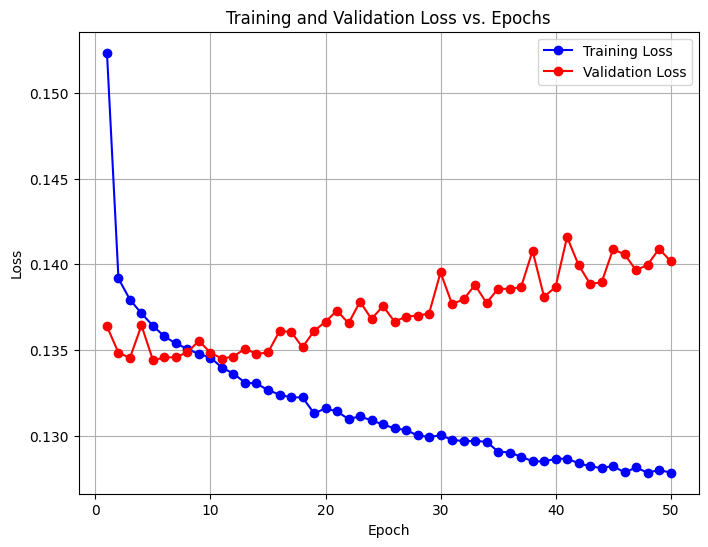

In [5]:
# Simple MLP
# ---------------------------
# Define a single-hidden-layer MLP
# ---------------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# ---------------------------
# Hyperparameters and placeholders
# ---------------------------
input_dim = 100
hidden_dim = 64
output_dim = 13

# Instantiate the model
model = SimpleMLP(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(train_data)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(valid_data)
val_loader  = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_epochs = 50

# Create a default BCEWithLogitsLoss for each column
criterion_list = []
for i in range(output_dim):
    loss_fn = nn.BCEWithLogitsLoss()
    criterion_list.append(loss_fn)

# ---------------------------
# Training Loop with Validation Loss Calculation
# ---------------------------
epoch_train_losses = []
epoch_val_losses = []

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    train_batches_seen = 0

    for batch_tensor in train_loader:
        (train_batch,) = batch_tensor

        # Split into embeddings and labels
        embeddings = train_batch[:, :-13] 
        labels = train_batch[:, -13:]

        loss_accum = 0.0
        valid_columns_count = 0

        # Loop over each of the 13 columns
        for i in range(output_dim):
            label_i = labels[:, i] 
            mask_i = ~torch.isnan(label_i)  # valid where label is not NaN

            if mask_i.sum() == 0:
                continue

            embeddings_i = embeddings[mask_i]
            label_i_valid = label_i[mask_i]

            logits = model(embeddings_i)
            logits_i = logits[:, i]

            loss_fn = criterion_list[i]
            loss_i = loss_fn(logits_i, label_i_valid.float())
            loss_accum += loss_i
            valid_columns_count += 1

        if valid_columns_count > 0:
            loss_final = loss_accum / valid_columns_count
            optimizer.zero_grad()
            loss_final.backward()
            optimizer.step()
            running_train_loss += loss_final.item()
            train_batches_seen += 1

    avg_train_loss = running_train_loss / train_batches_seen if train_batches_seen > 0 else 0.0
    epoch_train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    val_batches_seen = 0

    with torch.no_grad():
        for batch_tensor in val_loader:
            (val_batch,) = batch_tensor

            embeddings = val_batch[:, :-13]
            labels = val_batch[:, -13:]

            loss_accum = 0.0
            valid_columns_count = 0

            for i in range(output_dim):
                label_i = labels[:, i]
                mask_i = ~torch.isnan(label_i)

                if mask_i.sum() == 0:
                    continue

                embeddings_i = embeddings[mask_i]
                label_i_valid = label_i[mask_i]

                logits = model(embeddings_i)
                logits_i = logits[:, i]

                loss_fn = criterion_list[i]
                loss_i = loss_fn(logits_i, label_i_valid.float())
                loss_accum += loss_i
                valid_columns_count += 1

            if valid_columns_count > 0:
                loss_final = loss_accum / valid_columns_count
                running_val_loss += loss_final.item()
                val_batches_seen += 1

    avg_val_loss = running_val_loss / val_batches_seen if val_batches_seen > 0 else 0.0
    epoch_val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training complete!")

# ---------------------------
# Plotting Loss vs. Epochs, to check if there's overfitting
# ---------------------------
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(epoch_train_losses) + 1), epoch_train_losses, marker='o', linestyle='-', label='Training Loss', color='blue')
plt.plot(range(1, len(epoch_val_losses) + 1), epoch_val_losses, marker='o', linestyle='-', label='Validation Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()

Epoch [1/50], Train Loss: 0.1515, Val Loss: 0.1360
Epoch [2/50], Train Loss: 0.1388, Val Loss: 0.1350
Epoch [3/50], Train Loss: 0.1376, Val Loss: 0.1355
Epoch [4/50], Train Loss: 0.1369, Val Loss: 0.1354
Epoch [5/50], Train Loss: 0.1361, Val Loss: 0.1348
Epoch [6/50], Train Loss: 0.1356, Val Loss: 0.1346
Epoch [7/50], Train Loss: 0.1355, Val Loss: 0.1358
Epoch [8/50], Train Loss: 0.1350, Val Loss: 0.1354
Epoch [9/50], Train Loss: 0.1346, Val Loss: 0.1355
Epoch [10/50], Train Loss: 0.1343, Val Loss: 0.1351
Epoch [11/50], Train Loss: 0.1338, Val Loss: 0.1355
Early stopping triggered at epoch 11
Training complete!


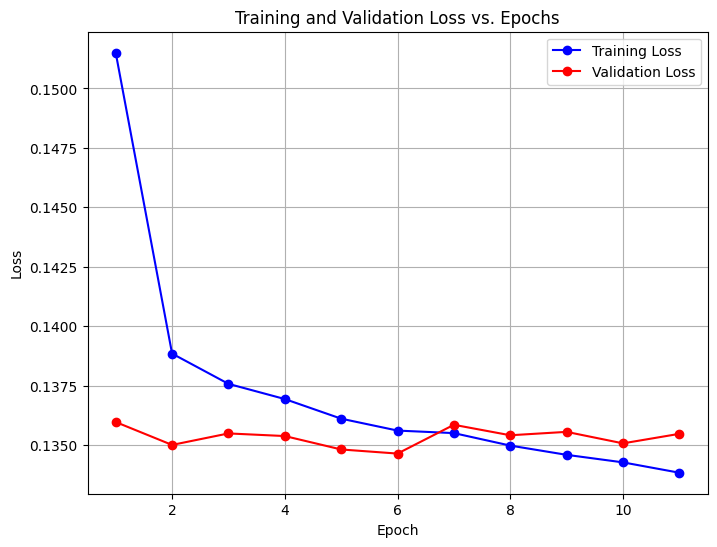

In [6]:
# Added early stopping
# ---------------------------
# Define a single-hidden-layer MLP
# ---------------------------
# now adding early stopping
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# ---------------------------
# Hyperparameters and placeholders
# ---------------------------
input_dim = 100
hidden_dim = 64
output_dim = 13

# Instantiate the model
model = SimpleMLP(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(train_data)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(valid_data)
val_loader  = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_epochs = 50  # This is maximum number of epochs
patience = 5     # Number of epochs to wait for improvement before stopping

# Create a default BCEWithLogitsLoss (no pos_weight) for each column
criterion_list = []
for i in range(output_dim):
    loss_fn = nn.BCEWithLogitsLoss()
    criterion_list.append(loss_fn)

# ---------------------------
# Training Loop with Validation, Early Stopping, and Loss Calculation
# ---------------------------
epoch_train_losses = []
epoch_val_losses = []

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    train_batches_seen = 0

    for batch_tensor in train_loader:
        (train_batch,) = batch_tensor

        # Split into embeddings and labels
        embeddings = train_batch[:, :-13]
        labels = train_batch[:, -13:]

        loss_accum = 0.0
        valid_columns_count = 0

        # Loop over each of the 13 columns
        for i in range(output_dim):
            label_i = labels[:, i] 
            mask_i = ~torch.isnan(label_i)   # valid where label is not NaN

            if mask_i.sum() == 0:
                continue

            embeddings_i = embeddings[mask_i]
            label_i_valid = label_i[mask_i]

            logits = model(embeddings_i)
            logits_i = logits[:, i]

            loss_fn = criterion_list[i]
            loss_i = loss_fn(logits_i, label_i_valid.float())
            loss_accum += loss_i
            valid_columns_count += 1

        if valid_columns_count > 0:
            loss_final = loss_accum / valid_columns_count
            optimizer.zero_grad()
            loss_final.backward()
            optimizer.step()

            running_train_loss += loss_final.item()
            train_batches_seen += 1

    avg_train_loss = running_train_loss / train_batches_seen if train_batches_seen > 0 else 0.0
    epoch_train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    val_batches_seen = 0

    with torch.no_grad():
        for batch_tensor in val_loader:
            (val_batch,) = batch_tensor

            embeddings = val_batch[:, :-13]
            labels = val_batch[:, -13:]

            loss_accum = 0.0
            valid_columns_count = 0

            for i in range(output_dim):
                label_i = labels[:, i]
                mask_i = ~torch.isnan(label_i)

                if mask_i.sum() == 0:
                    continue

                embeddings_i = embeddings[mask_i]
                label_i_valid = label_i[mask_i]

                logits = model(embeddings_i)
                logits_i = logits[:, i]

                loss_fn = criterion_list[i]
                loss_i = loss_fn(logits_i, label_i_valid.float())
                loss_accum += loss_i
                valid_columns_count += 1

            if valid_columns_count > 0:
                loss_final = loss_accum / valid_columns_count
                running_val_loss += loss_final.item()
                val_batches_seen += 1

    avg_val_loss = running_val_loss / val_batches_seen if val_batches_seen > 0 else 0.0
    epoch_val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # --- Early Stopping Check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("Training complete!")

# ---------------------------
# Plotting Loss vs. Epochs again
# ---------------------------
plt.figure(figsize=(8, 6))
epochs_range = range(1, len(epoch_train_losses) + 1)
plt.plot(epochs_range, epoch_train_losses, marker='o', linestyle='-', label='Training Loss', color='blue')
plt.plot(epochs_range, epoch_val_losses, marker='o', linestyle='-', label='Validation Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Testing phase

X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test).float()   # might contain NaNs

test_dataset = TensorDataset(test_data)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --------------------
# Evaluate multi-label accuracy and other metrics
# --------------------
# Put model in eval mode
model.eval()  

# Accumulate predictions, labels, and probabilities for each of the 13 columns
all_preds = [[] for _ in range(13)]
all_labels = [[] for _ in range(13)]
all_probs = [[] for _ in range(13)]

with torch.no_grad():
    for batch_tensor in test_loader:
        (test_batch,) = batch_tensor  # Unwrap from TensorDataset

        embeddings = test_batch[:, :-13]
        labels = test_batch[:, -13:]

        # Forward pass
        logits = model(embeddings) 

        # For each column, filter out NaNs and accumulate predictions, ground truths, and probabilities
        for i in range(13):
            label_i = labels[:, i]
            mask_i = ~torch.isnan(label_i)    # Boolean mask for valid entries

            if mask_i.sum() == 0:
                continue

            valid_labels = label_i[mask_i]
            valid_logits = logits[mask_i, i]

            # Convert logits to probabilities using sigmoid
            prob_i = torch.sigmoid(valid_logits)

            # Threshold at 0.5 for class predictions
            pred_i = (prob_i >= 0.5).long()

            # Extend lists using CPU numpy conversion
            all_preds[i].extend(pred_i.cpu().numpy())
            all_labels[i].extend(valid_labels.cpu().numpy())
            all_probs[i].extend(prob_i.cpu().numpy())

# --------------------
# Compute metrics for each column and build a results table
# --------------------
metrics_list = []
for i in range(13):
    if len(all_labels[i]) == 0:
        print(f"Column {i} has no valid labels; skipping metrics.")
        continue

    y_true = all_labels[i]
    y_pred = all_preds[i]
    y_prob = all_probs[i]  # this is for average_precision_score

    # Calculate per-class metrics: precision, recall and f1
    prec_array = precision_score(y_true, y_pred, labels=[0,1], average=None, zero_division=0)
    rec_array = recall_score(y_true, y_pred, labels=[0,1], average=None, zero_division=0)
    f1_array = f1_score(y_true, y_pred, labels=[0,1], average=None, zero_division=0)
    prec0, prec1 = prec_array
    rec0, rec1 = rec_array
    f1_0, f1_1 = f1_array

    # Overall accuracy
    acc = accuracy_score(y_true, y_pred)

    # Average precision for the "1" class
    avg_prec = average_precision_score(y_true, y_prob)

    metrics_list.append({
        "Label": i,
        "Accuracy": acc,
        "Average Precision": avg_prec,
        "Precision (Class 0)": prec0,
        "Recall (Class 0)": rec0,
        "F1 (Class 0)": f1_0,
        "Precision (Class 1)": prec1,
        "Recall (Class 1)": rec1,
        "F1 (Class 1)": f1_1,
    })

# Convert list for better presentation
results_df = pd.DataFrame(metrics_list)
print(results_df)

results_df.to_csv("results_simple.csv", index=False)

    Label  Accuracy  Average Precision  Precision (Class 0)  Recall (Class 0)  \
0       0  0.897766           0.569441             0.917676          0.969796   
1       1  0.906718           0.563915             0.922963          0.976577   
2       2  0.976558           0.313591             0.977153          0.999368   
3       3  0.967294           0.467427             0.973243          0.993397   
4       4  0.977960           0.101457             0.977960          1.000000   
5       5  0.973794           0.105689             0.973794          1.000000   
6       6  0.963173           0.308309             0.964308          0.998692   
7       7  0.864984           0.547190             0.884937          0.965124   
8       8  0.928959           0.680443             0.951205          0.970258   
9       9  0.984750           0.147534             0.986025          0.998683   
10     10  0.941459           0.390734             0.942906          0.997885   
11     11  0.984393         

In [8]:
# This also with the early stopping, but a Complex MLP
# ---------------------------------------------
# Define a Complex MLP for multi-label output
# ---------------------------------------------
class ComplexMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ComplexMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# ---------------------------------------------
# Hyperparameters and placeholders
# ---------------------------------------------
input_dim  = 100
output_dim = 13
batch_size = 32
num_epochs = 50
learning_rate = 0.001

# Early stopping parameters
patience = 5       # Number of epochs with no improvement to wait before stopping
best_val_loss = float('inf')
patience_counter = 0

# ---------------------------------------------
# Prepare training and validation datasets / dataloaders
# ---------------------------------------------
train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(valid_data)  # Assumes you have valid_data available
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------------------------
# Instantiate the model, criterion, optimizer
# ---------------------------------------------
model = ComplexMLP(input_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create a separate BCEWithLogitsLoss for each label.
criterion_list = [nn.BCEWithLogitsLoss() for _ in range(output_dim)]

# For plotting purposes
epoch_train_losses = []
epoch_val_losses = []

# ---------------------------------------------
# Training loop with Early Stopping
# ---------------------------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batches_seen = 0

    for batch_tensor in train_loader:
        (train_batch,) = batch_tensor

        # split embeddings vs. labels
        embeddings = train_batch[:, :input_dim] 
        labels = train_batch[:, input_dim:] 

        loss_accum = 0.0
        valid_columns_count = 0

        # For each of the 13 label columns
        for i in range(output_dim):
            label_i = labels[:, i]
            mask_i = ~torch.isnan(label_i)    # Boolean mask for valid labels

            if mask_i.sum() == 0:
                continue

            # Subset embeddings and labels where label_i is not NaN
            embeddings_i = embeddings[mask_i]
            label_i_valid = label_i[mask_i]

            # Forward pass
            logits = model(embeddings_i) 
            logits_i = logits[:, i]

            loss_fn = criterion_list[i]
            loss_i = loss_fn(logits_i, label_i_valid.float())

            loss_accum += loss_i
            valid_columns_count += 1

        if valid_columns_count > 0:
            loss_final = loss_accum / valid_columns_count
            optimizer.zero_grad()
            loss_final.backward()
            optimizer.step()

            running_loss += loss_final.item()
            batches_seen += 1

    avg_train_loss = running_loss / batches_seen if batches_seen > 0 else 0.0
    epoch_train_losses.append(avg_train_loss)

    # ---------------------------------------------
    # Validation Phase
    # ---------------------------------------------
    model.eval()
    running_val_loss = 0.0
    val_batches_seen = 0
    with torch.no_grad():
        for batch_tensor in val_loader:
            (val_batch,) = batch_tensor

            embeddings = val_batch[:, :input_dim]
            labels = val_batch[:, input_dim:]

            loss_accum = 0.0
            valid_columns_count = 0

            for i in range(output_dim):
                label_i = labels[:, i]
                mask_i = ~torch.isnan(label_i)
                if mask_i.sum() == 0:
                    continue
                embeddings_i = embeddings[mask_i]
                label_i_valid = label_i[mask_i]

                logits = model(embeddings_i)
                logits_i = logits[:, i]

                loss_fn = criterion_list[i]
                loss_i = loss_fn(logits_i, label_i_valid.float())

                loss_accum += loss_i
                valid_columns_count += 1

            if valid_columns_count > 0:
                loss_final = loss_accum / valid_columns_count
                running_val_loss += loss_final.item()
                val_batches_seen += 1

    avg_val_loss = running_val_loss / val_batches_seen if val_batches_seen > 0 else 0.0
    epoch_val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # ---------------------------------------------
    # Early Stopping check
    # ---------------------------------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("Training complete!")

Epoch [1/50], Train Loss: 0.1515, Val Loss: 0.1369
Epoch [2/50], Train Loss: 0.1411, Val Loss: 0.1366
Epoch [3/50], Train Loss: 0.1388, Val Loss: 0.1369
Epoch [4/50], Train Loss: 0.1380, Val Loss: 0.1355
Epoch [5/50], Train Loss: 0.1368, Val Loss: 0.1351
Epoch [6/50], Train Loss: 0.1352, Val Loss: 0.1355
Epoch [7/50], Train Loss: 0.1343, Val Loss: 0.1347
Epoch [8/50], Train Loss: 0.1331, Val Loss: 0.1350
Epoch [9/50], Train Loss: 0.1321, Val Loss: 0.1357
Epoch [10/50], Train Loss: 0.1307, Val Loss: 0.1361
Epoch [11/50], Train Loss: 0.1292, Val Loss: 0.1389
Epoch [12/50], Train Loss: 0.1275, Val Loss: 0.1388
Early stopping triggered at epoch 12
Training complete!


In [9]:
# testing phase
X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test).float()

test_dataset = TensorDataset(test_data)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --------------------
# Evaluate multi-label accuracy and other metrics
# --------------------
model.eval()

# Accumulate predictions, labels, and probabilities for each of the 13 columns
all_preds = [[] for _ in range(13)]
all_labels = [[] for _ in range(13)]
all_probs = [[] for _ in range(13)]

with torch.no_grad():
    for batch_tensor in test_loader:
        (test_batch,) = batch_tensor

        embeddings = test_batch[:, :-13]
        labels = test_batch[:, -13:]

        # Forward pass
        logits = model(embeddings) 

        # For each column, filter out NaNs and accumulate predictions, ground truths, and probabilities
        for i in range(13):
            label_i = labels[:, i] 
            mask_i = ~torch.isnan(label_i)      # Boolean mask for valid entries

            if mask_i.sum() == 0:
                continue

            valid_labels = label_i[mask_i]
            valid_logits = logits[mask_i, i]

            # Convert logits to probabilities using sigmoid
            prob_i = torch.sigmoid(valid_logits)

            # Threshold at 0.5 for class predictions
            pred_i = (prob_i >= 0.5).long()

            # Extend lists using CPU numpy conversion
            all_preds[i].extend(pred_i.cpu().numpy())
            all_labels[i].extend(valid_labels.cpu().numpy())
            all_probs[i].extend(prob_i.cpu().numpy())

# --------------------
# Compute metrics for each column and build a results table
# --------------------
metrics_list = []
for i in range(13):
    if len(all_labels[i]) == 0:
        print(f"Column {i} has no valid labels; skipping metrics.")
        continue

    y_true = all_labels[i]
    y_pred = all_preds[i]
    y_prob = all_probs[i]  # for average_precision_score

    # Calculate per-class metrics: precision, recall and f1
    prec_array = precision_score(y_true, y_pred, labels=[0, 1], average=None, zero_division=0)
    rec_array = recall_score(y_true, y_pred, labels=[0, 1], average=None, zero_division=0)
    f1_array = f1_score(y_true, y_pred, labels=[0, 1], average=None, zero_division=0)
    prec0, prec1 = prec_array
    rec0, rec1 = rec_array
    f1_0, f1_1 = f1_array

    # Overall accuracy
    acc = accuracy_score(y_true, y_pred)

    # Average precision for the 1 class
    avg_prec = average_precision_score(y_true, y_prob)

    metrics_list.append({
        "Label": i,
        "Accuracy": acc,
        "Average Precision": avg_prec,
        "Precision (Class 0)": prec0,
        "Recall (Class 0)": rec0,
        "F1 (Class 0)": f1_0,
        "Precision (Class 1)": prec1,
        "Recall (Class 1)": rec1,
        "F1 (Class 1)": f1_1,
    })

# Convert list for better presentation
results_df = pd.DataFrame(metrics_list)
print(results_df)


results_df.to_csv("results_comlex.csv", index=False)


    Label  Accuracy  Average Precision  Precision (Class 0)  Recall (Class 0)  \
0       0  0.897766           0.547855             0.918456          0.968812   
1       1  0.904498           0.539760             0.916861          0.981574   
2       2  0.976249           0.278415             0.977737          0.998421   
3       3  0.966136           0.459605             0.970993          0.994598   
4       4  0.977960           0.116285             0.977960          1.000000   
5       5  0.974433           0.132897             0.974416          1.000000   
6       6  0.964432           0.318587             0.966709          0.997383   
7       7  0.864984           0.550944             0.884478          0.965776   
8       8  0.927874           0.661575             0.947680          0.972989   
9       9  0.984750           0.170440             0.985710          0.999013   
10     10  0.941176           0.386414             0.942132          0.998489   
11     11  0.984393         

Epoch [1/50], Train Loss: 0.2951, Val Loss: 0.2706
Epoch [2/50], Train Loss: 0.2766, Val Loss: 0.2699
Epoch [3/50], Train Loss: 0.2741, Val Loss: 0.2686
Epoch [4/50], Train Loss: 0.2729, Val Loss: 0.2702
Epoch [5/50], Train Loss: 0.2716, Val Loss: 0.2699
Epoch [6/50], Train Loss: 0.2698, Val Loss: 0.2706
Epoch [7/50], Train Loss: 0.2694, Val Loss: 0.2690
Epoch [8/50], Train Loss: 0.2688, Val Loss: 0.2682
Epoch [9/50], Train Loss: 0.2667, Val Loss: 0.2695
Epoch [10/50], Train Loss: 0.2663, Val Loss: 0.2703
Epoch [11/50], Train Loss: 0.2659, Val Loss: 0.2712
Epoch [12/50], Train Loss: 0.2645, Val Loss: 0.2706
Epoch [13/50], Train Loss: 0.2635, Val Loss: 0.2730
Epoch [14/50], Train Loss: 0.2638, Val Loss: 0.2718
Epoch [15/50], Train Loss: 0.2623, Val Loss: 0.2725
Epoch [16/50], Train Loss: 0.2621, Val Loss: 0.2723
Epoch [17/50], Train Loss: 0.2617, Val Loss: 0.2733
Epoch [18/50], Train Loss: 0.2601, Val Loss: 0.2726
Early stopping triggered at epoch 18
Training complete!


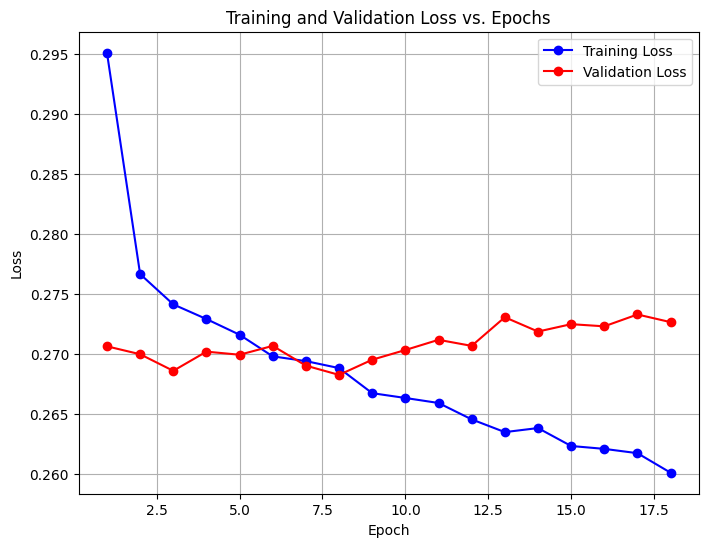

In [10]:
# this is early stopping with weight added, also together with the plot of epoch
# Define your simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ---------------------------
# Hyperparameters and placeholders
# ---------------------------
input_dim = 100
hidden_dim = 64
output_dim = 13

model = SimpleMLP(input_dim, hidden_dim, output_dim)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create datasets and dataloaders for training and validation
train_dataset = TensorDataset(train_data)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(valid_data)
val_loader  = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_epochs = 50 # Maximum number of epochs

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
patience_counter = 0

# Define a pos_weight > 1.0 for each column if you want to up-weight positives
pos_weight_list = []
pos_weight_value = 3.0  # up-weight the positive class by factor of 3
for i in range(output_dim):
    pos_weight = torch.tensor([pos_weight_value])
    pos_weight_list.append(pos_weight)

criterion_list = []
for i in range(output_dim):
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_list[i])
    criterion_list.append(loss_fn)

# Lists to store the loss of each epoch
epoch_train_losses = []
epoch_val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    train_batches_seen = 0

    for batch_tensor in train_loader:
        (train_batch,) = batch_tensor

        embeddings = train_batch[:, :-13]
        labels = train_batch[:, -13:]

        loss_accum = 0.0
        valid_columns_count = 0

        # Loop over each of the 13 output columns
        for i in range(output_dim):
            label_i = labels[:, i]  
            mask_i = ~torch.isnan(label_i) 

            if mask_i.sum() == 0:
                continue

            embeddings_i = embeddings[mask_i]
            label_i_valid = label_i[mask_i]

            logits = model(embeddings_i) 
            logits_i = logits[:, i]

            loss_fn = criterion_list[i]
            loss_i = loss_fn(logits_i, label_i_valid.float())

            loss_accum += loss_i
            valid_columns_count += 1

        if valid_columns_count > 0:
            loss_final = loss_accum / valid_columns_count
            optimizer.zero_grad()
            loss_final.backward()
            optimizer.step()

            running_train_loss += loss_final.item()
            train_batches_seen += 1

    avg_train_loss = running_train_loss / train_batches_seen if train_batches_seen > 0 else 0.0
    epoch_train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    val_batches_seen = 0
    with torch.no_grad():
        for batch_tensor in val_loader:
            (val_batch,) = batch_tensor 
            embeddings = val_batch[:, :-13]
            labels = val_batch[:, -13:]

            loss_accum = 0.0
            valid_columns_count = 0

            for i in range(output_dim):
                label_i = labels[:, i] 
                mask_i = ~torch.isnan(label_i)

                if mask_i.sum() == 0:
                    continue

                embeddings_i = embeddings[mask_i]
                label_i_valid = label_i[mask_i]

                logits = model(embeddings_i)
                logits_i = logits[:, i]

                loss_fn = criterion_list[i]
                loss_i = loss_fn(logits_i, label_i_valid.float())

                loss_accum += loss_i
                valid_columns_count += 1

            if valid_columns_count > 0:
                loss_final = loss_accum / valid_columns_count
                running_val_loss += loss_final.item()
                val_batches_seen += 1

    avg_val_loss = running_val_loss / val_batches_seen if val_batches_seen > 0 else 0.0
    epoch_val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping: Check if validation loss has improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("Training complete!")

# Plotting Loss vs. Epochs for both training and validation
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(epoch_train_losses) + 1), epoch_train_losses, marker='o', linestyle='-', label='Training Loss', color='blue')
plt.plot(range(1, len(epoch_val_losses) + 1), epoch_val_losses, marker='o', linestyle='-', label='Validation Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [11]:

#  Test phase 
model.eval() 

# Store predictions, labels, and probabilities for each of the 13 columns
all_preds = [[] for _ in range(output_dim)]
all_labels = [[] for _ in range(output_dim)]
all_probs = [[] for _ in range(output_dim)]  # for average_precision_score

with torch.no_grad():
    for batch_tensor in test_loader:
        (test_batch,) = batch_tensor 

        embeddings = test_batch[:, :input_dim]  
        labels = test_batch[:, input_dim:]

        # Forward pass
        logits = model(embeddings)

        # For each column, filter out NaNs and accumulate predictions, ground truths, and probabilities again
        for i in range(output_dim):
            label_i = labels[:, i] 
            mask_i = ~torch.isnan(label_i)

            if mask_i.sum() == 0:
                continue

            valid_labels = label_i[mask_i]
            valid_logits = logits[mask_i, i]

            # Convert logits to probabilities using sigmoid
            prob_i = torch.sigmoid(valid_logits)

            # Threshold at 0.5 for binary predictions
            pred_i = (prob_i >= 0.5).long()

            # Extend lists using CPU numpy conversion
            all_labels[i].extend(valid_labels.cpu().numpy())
            all_preds[i].extend(pred_i.cpu().numpy())
            all_probs[i].extend(prob_i.cpu().numpy())

# ---------------------------
# Compute metrics for each column and build a results table
# ---------------------------
metrics_list = []
for i in range(output_dim):
    if len(all_labels[i]) == 0:
        print(f"Column {i} has no valid labels; skipping metrics.")
        continue

    y_true = all_labels[i]
    y_pred = all_preds[i]
    y_prob = all_probs[i]  # for average_precision_score

    # Calculate per-class metrics: precision, recall, and F1 score
    prec_array = precision_score(y_true, y_pred, labels=[0, 1], average=None, zero_division=0)
    rec_array = recall_score(y_true, y_pred, labels=[0, 1], average=None, zero_division=0)
    f1_array = f1_score(y_true, y_pred, labels=[0, 1], average=None, zero_division=0)
    prec0, prec1 = prec_array
    rec0, rec1 = rec_array
    f1_0, f1_1 = f1_array

    # Overall accuracy
    acc = accuracy_score(y_true, y_pred)

    # Average precision for the positive class (assumes label "1" is the positive label)
    avg_prec = average_precision_score(y_true, y_prob)

    metrics_list.append({
        "Label": i,
        "Accuracy": acc,
        "Average Precision": avg_prec,
        "Precision (Class 0)": prec0,
        "Recall (Class 0)": rec0,
        "F1 (Class 0)": f1_0,
        "Precision (Class 1)": prec1,
        "Recall (Class 1)": rec1,
        "F1 (Class 1)": f1_1,
    })

# For better presentation and print the results
results_df = pd.DataFrame(metrics_list)
print(results_df)

results_df.to_csv("results_weighted.csv", index=False)

    Label  Accuracy  Average Precision  Precision (Class 0)  Recall (Class 0)  \
0       0  0.879439           0.558862             0.941770          0.918582   
1       1  0.880900           0.541338             0.955636          0.908182   
2       2  0.971006           0.331829             0.985466          0.984844   
3       3  0.964110           0.490904             0.982551          0.980192   
4       4  0.971977           0.112875             0.979345          0.992273   
5       5  0.969000           0.120428             0.975500          0.993108   
6       6  0.951212           0.286068             0.975426          0.973831   
7       7  0.837816           0.545447             0.934104          0.868644   
8       8  0.923265           0.680429             0.969451          0.943854   
9       9  0.978261           0.187983             0.989134          0.988808   
10     10  0.921946           0.386878             0.958863          0.957704   
11     11  0.981154         

In [12]:
from imblearn.over_sampling import SMOTE
# now use SMOTE to re-sampling
# ---------------------------
# Define a simple MLP
# ---------------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ---------------------------
# Hyperparameters / shapes
# ---------------------------
input_dim = 100
hidden_dim = 64
num_labels = 13
batch_size = 32
num_epochs = 50   # max number of epochs

# Early stopping parameters
patience = 5  # number of epochs to wait without improvement before stopping

# We'll store a separate trained model for each label index
label_models = {}

# ---------------------------
# Train each label-model with SMOTE
# ---------------------------
for label_idx in range(num_labels):
    print(f"\n=== Training label {label_idx} / {num_labels - 1} ===")

    # Split out features (X) and this label (y_i) from train_data
    X_all = train_data[:, :input_dim] 
    y_all = train_data[:, input_dim + label_idx] 

    # Filter out NaNs for this label
    mask = ~torch.isnan(y_all)
    X_valid = X_all[mask]
    y_valid = y_all[mask]

    if X_valid.size(0) == 0:
        print(f"  - No valid samples for label {label_idx}. Skipping.")
        continue

    # Convert to NumPy for SMOTE
    X_np = X_valid.cpu().numpy()
    y_np = y_valid.cpu().numpy().astype(int)  # SMOTE expects binary int 0/1

    # If only one class is present, SMOTE will fail
    if len(np.unique(y_np)) < 2:
        print(f"  - Label {label_idx}: Only one class present. Skipping SMOTE/training.")
        continue

    # Apply SMOTE to oversample minority class
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_np, y_np)

    # Convert back to Torch
    X_res_t = torch.tensor(X_resampled, dtype=torch.float32)
    y_res_t = torch.tensor(y_resampled, dtype=torch.float32).view(-1, 1)

    # Combine features + label
    train_data_label_i = torch.cat([X_res_t, y_res_t], dim=1)
    ds_label_i = TensorDataset(train_data_label_i)

    # DataLoader for this label
    loader_label_i = DataLoader(ds_label_i, batch_size=batch_size, shuffle=True)

    # Instantiate model, criterion, optimizer
    model_i = SimpleMLP(input_dim, hidden_dim, 1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_i.parameters(), lr=0.001)

    # Early stopping initialization for this label
    best_loss = float('inf')
    patience_counter = 0

    #  Training loop with early stopping
    for epoch in range(num_epochs):
        model_i.train()
        running_loss = 0.0
        for (batch_t,) in loader_label_i:
            xb = batch_t[:, :input_dim]
            yb = batch_t[:, input_dim:]

            logits = model_i(xb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(loader_label_i)
        #print(f"   Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"   Early stopping triggered at epoch {epoch+1}")
                break

    # Store the trained model for this label
    label_models[label_idx] = model_i
    print(f"   - Finished training label {label_idx}.")

print("\nAll label-by-label training complete.")



=== Training label 0 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 0.

=== Training label 1 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 1.

=== Training label 2 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 2.

=== Training label 3 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 3.

=== Training label 4 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 4.

=== Training label 5 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 5.

=== Training label 6 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 6.

=== Training label 7 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 7.

=== Training label 8 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 8.

=== Training label 9 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 9.

=== Training label 10 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 10.

=== Training label 11 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 11.

=== Training label 12 / 12 ===


/Users/cuprum/.miniconda3/envs/sph6004/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   - Finished training label 12.

All label-by-label training complete.


In [13]:

# Testing phase

X_test_all = test_data[:, :input_dim] 
Y_test_all = test_data[:, input_dim:]

metrics_list = []

for label_idx in range(num_labels):
    #print(f"\n=== Evaluating label {label_idx} ===")
    
    if label_idx not in label_models:
        #print(f"  - No trained model found for label {label_idx}. Skipping.")
        continue
    
    model_i = label_models[label_idx]
    label_test = Y_test_all[:, label_idx]  # shape: [N_test]
    
    # Filter out NaNs
    mask_test = ~torch.isnan(label_test)
    X_test_valid = X_test_all[mask_test]
    y_test_valid = label_test[mask_test]
    
    if X_test_valid.size(0) == 0:
        #print(f"  - No valid test samples for label {label_idx}. Skipping.")
        continue
    
    # Move to CPU numpy for inference
    X_test_np = X_test_valid.cpu().numpy()
    y_test_np = y_test_valid.cpu().numpy().astype(int)
    
    # Forward pass
    model_i.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_test_np, dtype=torch.float32)
        logits = model_i(X_tensor) 
        probs = torch.sigmoid(logits).squeeze(1)
        preds = (probs >= 0.5).long()
    
    # Convert to numpy arrays
    y_pred = preds.cpu().numpy()
    y_prob = probs.cpu().numpy()
    
    # Compute metrics per label
    # For precision, recall, F1 for both classes 0 and 1:
    prec_array = precision_score(y_test_np, y_pred, labels=[0, 1], average=None, zero_division=0)
    rec_array  = recall_score(y_test_np, y_pred, labels=[0, 1], average=None, zero_division=0)
    f1_array   = f1_score(y_test_np, y_pred, labels=[0, 1], average=None, zero_division=0)
    
    prec0, prec1 = prec_array
    rec0, rec1   = rec_array
    f1_0, f1_1   = f1_array
    
    acc = accuracy_score(y_test_np, y_pred)
    avg_prec = average_precision_score(y_test_np, y_prob)
    
    metrics_list.append({
        "Label": label_idx,
        "Accuracy": acc,
        "Average Precision": avg_prec,
        "Precision (Class 0)": prec0,
        "Recall (Class 0)": rec0,
        "F1 (Class 0)": f1_0,
        "Precision (Class 1)": prec1,
        "Recall (Class 1)": rec1,
        "F1 (Class 1)": f1_1,
    })
    
    #print(f"Label {label_idx}:")
    #print(f"  Class 0: Precision={prec0:.4f}, Recall={rec0:.4f}, F1={f1_0:.4f}")
    #print(f"  Class 1: Precision={prec1:.4f}, Recall={rec1:.4f}, F1={f1_1:.4f}")
    #print(f"  Accuracy={acc:.4f}, Average Precision (class 1)={avg_prec:.4f}")

# Tabulated summary:
results_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(results_df)

results_df.to_csv("results_SMOTE.csv", index=False)



Evaluation Metrics:
    Label  Accuracy  Average Precision  Precision (Class 0)  Recall (Class 0)  \
0       0  0.832188           0.443495             0.937100          0.865726   
1       1  0.843420           0.396904             0.948030          0.871643   
2       2  0.956200           0.160967             0.982149          0.972845   
3       3  0.946165           0.344041             0.982219          0.961585   
4       4  0.950252           0.115292             0.982646          0.966194   
5       5  0.927453           0.089908             0.978615          0.946177   
6       6  0.922568           0.193695             0.974350          0.944390   
7       7  0.819704           0.439878             0.908783          0.873533   
8       8  0.902657           0.535655             0.959324          0.930501   
9       9  0.975341           0.113182             0.987492          0.987492   
10     10  0.853790           0.234698             0.958320          0.882175   
11     